In [1]:
# ------------------------------------------------
# Script for data analysis
# Full name: 1d_revised_grid_reflecting_version2_analysis
# (trial 1 in the paper)
# ------------------------------------------------

using StatsBase
using Distributions
using Plots
using SpecialFunctions
using Serialization

default(margin=6Plots.mm) # plot parameters

In [2]:
# Input parameters
# ------------------------------------------------

const BURN_IN_GEN_N = 10000
const TOTAL_GEN_N = 12500

# Max coordinates of the population bounding space
const X_MAX_BURN_IN = 5
const X_MAX = 500

const X_START = X_MAX_BURN_IN

# Dimensions of the whole space
const X_DIM = X_MAX

# Population parameters
#const INIT_PERSON_N = 30
const DEMES_FULL_AT_START = 5
const K_CAPACITY = 100
const R_PROLIF_RATE = 2
const r_LOG_PROLIF_RATE = log(2)

# Gene parameters
const LOCI_N = 20
const MUT_RATE = 0.05
const M_MIG_RATE = 0.05
const MUT_DELETER_RATE = 0.9
const S_SELECT_COEF = 0.005

0.005

In [3]:
# Data loading
# ------------------------------------------------

const N_IN_BATCH = 9 # The number used in the paper is 70. Due to limitations in the file size, we have only provided 9 here

padding = zeros(Float32,X_DIM,BURN_IN_GEN_N)
meanfitness_set_noburn = [hcat(padding,deserialize("../data/1d/r_gridrefl2_noburn_$i-meanf.dat")[:,1:(TOTAL_GEN_N-BURN_IN_GEN_N)]) for i in 1:N_IN_BATCH]
meanfitness_set = [deserialize("../data/1d/r_gridrefl2_$i-meanf.dat") for i in 1:N_IN_BATCH]

9-element Vector{Matrix{Float32}}:
 [1.0 0.9995113 … 13.005792 13.008043; 1.0 0.99952203 … 13.317048 13.360856; … ; -1.0 -1.0 … 2.2668674 2.2598007; -1.0 -1.0 … 2.2354066 2.2418978]
 [1.0 0.999717 … 16.529295 16.43005; 1.0 0.99962264 … 16.427404 16.467009; … ; -1.0 -1.0 … 3.3990877 3.4050713; -1.0 -1.0 … 3.4353302 3.4385736]
 [1.0 0.9993942 … 15.360973 15.414511; 1.0 0.9993627 … 15.738379 15.673623; … ; -1.0 -1.0 … 2.9565635 2.9568853; -1.0 -1.0 … 2.9715142 2.981907]
 [1.0 0.99971825 … 16.024973 16.02886; 1.0 0.99979585 … 16.288136 16.286394; … ; -1.0 -1.0 … 3.8192158 3.8012583; -1.0 -1.0 … 3.7924852 3.8010743]
 [1.0 0.99941796 … 15.236584 15.264412; 1.0 0.9995145 … 15.293317 15.255664; … ; -1.0 -1.0 … 3.2469857 3.2527914; -1.0 -1.0 … 3.2126925 3.2101715]
 [1.0 0.999628 … 18.367443 18.443232; 1.0 0.99965996 … 18.342613 18.449955; … ; -1.0 -1.0 … 3.9952707 4.0175376; -1.0 -1.0 … 4.023067 4.0133758]
 [1.0 0.9995408 … 14.649035 14.6239195; 1.0 0.9998261 … 14.72448 14.678687; … ; -1.0 -1.0

In [4]:
# Functions pertaining to the expansion front
# ------------------------------------------------

function get_normalised_matrix_max(meanfit_array)
    normal_array = copy(meanfit_array)
    for j in 1:(TOTAL_GEN_N-BURN_IN_GEN_N)
        gen_max = maximum(meanfit_array[:,BURN_IN_GEN_N+j])
        normal_array[:,BURN_IN_GEN_N+j] /= gen_max
    end
    return normal_array
end

function get_normalised_matrix_onset_mean(meanfit_array)
    normal_array = copy(meanfit_array)
    
    sum = 0
    count = 0
    for u in meanfit_array[:,BURN_IN_GEN_N+1]
        if u > 0
            sum += u
            count += 1
        end
    end
    gen_max = sum/count

    normal_array[:,BURN_IN_GEN_N+1:end] /= gen_max
    return normal_array
end

function find_front(meanfit_array,gen_n=TOTAL_GEN_N)
    front_array = Array{Float32}(undef,0)
    for j in 1:gen_n
        frontier = X_MAX
        while frontier != 1 && meanfit_array[frontier,j] < 0
            frontier -= 1
        end
        sum_total = meanfit_array[frontier,j]
        front_array = cat(front_array,sum_total, dims=1)
    end
    return front_array
end

function normalise_onset_mean(average_1d_array)
    normal_array = copy(average_1d_array)
    
    sum = 0
    count = 0
    for u in average_1d_array[BURN_IN_GEN_N+1]
        if u > 0
            sum += u
            count += 1
        end
    end
    gen_max = sum/count

    normal_array[BURN_IN_GEN_N+1:end] /= gen_max
    return normal_array
end

normalise_onset_mean (generic function with 1 method)

In [5]:
# Normalisation algorithm (order) I
# ------------------------------------------------

mf_norm_set = [get_normalised_matrix_max(k) for k in meanfitness_set]
mf_front_norm_set = [find_front(k) for k in mf_norm_set]

#= mf_norm_set2 = [get_normalised_matrix_onset_mean(k) for k in meanfitness_set]
mf_front_norm_set2 = [find_front(k) for k in mf_norm_set2] =#

#= mf_norm_set_noburn = [get_normalised_matrix_onset_mean(k) for k in meanfitness_set_noburn]
mf_front_norm_set_noburn = [find_front(k) for k in mf_norm_set_noburn] =#

9-element Vector{Vector{Float32}}:
 [1.0, 1.0, 0.99954957, 0.9994146, 0.99892545, 0.99826163, 0.99760145, 0.9969926, 0.9960431, 0.9959385  …  0.15716328, 0.15693077, 0.15756464, 0.1567049, 0.15617147, 0.15725923, 0.15709886, 0.15671, 0.15590505, 0.15641499]
 [1.0, 0.99954516, 0.9988473, 0.99795574, 0.9970038, 0.9960876, 0.99575365, 0.9950119, 0.99486727, 0.9931994  …  0.17703576, 0.17682727, 0.17633761, 0.17613438, 0.1764029, 0.17643553, 0.17677206, 0.17801082, 0.17779619, 0.17726186]
 [1.0, 0.9996465, 0.9989397, 0.9987634, 0.9988577, 0.9985272, 0.99810714, 0.99742335, 0.99764335, 0.9972099  …  0.16306618, 0.16298498, 0.16378284, 0.16281205, 0.16189572, 0.16266693, 0.16235475, 0.16237952, 0.16105764, 0.16151787]
 [1.0, 0.9994122, 0.9992636, 0.99903136, 0.99845535, 0.99856246, 0.9980616, 0.99708647, 0.99658275, 0.996118  …  0.20039235, 0.19904487, 0.20018592, 0.1995245, 0.20078072, 0.20046003, 0.2002567, 0.20043194, 0.19990504, 0.2000956]
 [1.0, 0.99989253, 0.9998113, 0.9992649, 0.99876

In [6]:
# Normalisation algorithm (order) II
# ------------------------------------------------

mf_front_set = [find_front(meanfitness_set[i]) for i in 1:N_IN_BATCH]
mf_front_matrix = reduce(hcat,mf_front_set)'
mf_front_average = [mean(mf_front_matrix[:,i]) for i in 1:TOTAL_GEN_N]
mf_front_average_then_norm = normalise_onset_mean(mf_front_average)

mf_front_set_noburn = [find_front(k) for k in meanfitness_set_noburn]
mf_front_matrix_noburn = reduce(hcat,mf_front_set_noburn)'
mf_front_average_noburn = [mean(mf_front_matrix_noburn[:,i]) for i in 1:TOTAL_GEN_N]

12500-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.4717395
 0.4716968
 0.47122335
 0.47101963
 0.472107
 0.4723107
 0.47215307
 0.472026
 0.472898

In [7]:
# Compare norm. algorithms I & II
# ------------------------------------------------

#= plot(mf_front_norm_average2,label="I ($N_IN_BATCH sims)")
plot!(mf_front_average_then_norm,label="II ($N_IN_BATCH sims)",linestyle=:dash) =#

In [8]:
# Plot to check all simulation iterates
# ------------------------------------------------

#= slow_down = 1
gen_start = 11000
gen_end = 11100

@gif for i=gen_start:(gen_end*slow_down-1)
    gen_no = trunc(Int,i/slow_down)+1
    heatmap(reshape(populations[:,gen_no],1,length(populations[:,gen_no])),aspect_ratio=1,yticks=false,clims=(0,K_CAPACITY),xlabel="gen=$gen_no")
end =#

In [9]:
#= plot1 = plot(mf_front_norm_set[1][BURN_IN_GEN_N+1:end],label = "Sim.#1",xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.46,1.04))

for i in 2:N_IN_BATCH
    plot1 = plot!(mf_front_norm_set[i][BURN_IN_GEN_N+1:end],legend=false,xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.46,1.04))
end
display(plot1) =#

In [7]:
mf_front_norm_matrix = reduce(hcat,mf_front_norm_set)'
mf_front_norm_average = [mean(mf_front_norm_matrix[:,i]) for i in 1:TOTAL_GEN_N]

12500-element Vector{Float32}:
 1.0
 0.9996909
 0.99929863
 0.9988454
 0.9985082
 0.9980171
 0.99748474
 0.99685264
 0.9966277
 0.9962146
 ⋮
 0.18262854
 0.18268758
 0.1821208
 0.18212414
 0.18201976
 0.18183815
 0.18190308
 0.18174578
 0.18195975

In [11]:
# Plot to check all simulation iterates
# ------------------------------------------------

#= plot1 = plot(mf_front_norm_set2[1][BURN_IN_GEN_N+1:end],label = "Sim.#1",xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.66,1.04))

for i in 2:N_IN_BATCH
    plot1 = plot!(mf_front_norm_set2[i][BURN_IN_GEN_N+1:end],legend=false,xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.66,1.04))
end
display(plot1) =#

In [12]:
#= mf_front_norm_matrix2 = reduce(hcat,mf_front_norm_set2)'
mf_front_norm_average2 = [mean(mf_front_norm_matrix2[:,i]) for i in 1:TOTAL_GEN_N] =#

In [13]:
# Proof that the 'onset mean' normalisation is optimal, since it replicates the same simulations but with no burn-in
# ------------------------------------------------

#= plot(mf_front_norm_average[BURN_IN_GEN_N+1:end],label = "Av.over $N_IN_BATCH sims,max norm.",xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.46,1.04))
plot!(mf_front_norm_average2[BURN_IN_GEN_N+1:end],label = "Av.over $N_IN_BATCH sims,onset mean norm.",xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.46,1.04))
plot!(mf_front_average_noburn[BURN_IN_GEN_N+1:end],label = "Av.over $N_IN_BATCH sims,no burn-in",xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.46,1.04)) =#

In [14]:
# Check that no-burn-in simulations are equivalent to their normalised versions
# ------------------------------------------------

#= mf_front_norm_matrix_noburn = reduce(hcat,mf_front_norm_set_noburn)'
mf_front_norm_average_noburn = [mean(mf_front_norm_matrix_noburn[:,i]) for i in 1:TOTAL_GEN_N]
mf_front_norm_set_noburn==mf_front_set_noburn =#

In [8]:
# Analytical function definitions
# ------------------------------------------------

function N_t(m,r,K,t)
    x_ = (m/2)*K*exp(r*t)
    if x_ >= K
        x_ =  K
    end
    return x_
end

function growth_T(m,r)
    return log(2/m)/r
end

function s_e(s,m,r)
    return s*(m/2)*growth_T(m,r)
end

function x0(s,m,r,K,t)
    x_ = exp(s*(growth_T(m,r)-t))
    x_ /= (exp(s*(growth_T(m,r)-t))+2*N_t(m,r,K,t)-1)
    return x_
end

function u_p_cubic(P,s,m,r,K)
    local myexp = exp(s*growth_T(m,r))
    
    return (3*myexp*(myexp-1)*P-K*m*((myexp-1)*P+1)^3+K*m)/(3*myexp*(myexp-1)-K*m*myexp^3+K*m)
end

h2(s,m,r,K) = sqrt(exp(-s*growth_T(m,r))*K*m) # A* in my PDF
h1(s,m,r) = expm1(s*growth_T(m,r)) # B in my PDF

function u_p(P,s,m,r,K)
    local myh1 = h1(s,m,r)
    local myh2 = h2(s,m,r,K)
    u_ = erf(myh1*myh2*P+myh2)-erf(myh2)
    u_ /= erf(myh1*myh2+myh2)-erf(myh2)
    return u_
end

function u_p_peischl(P,s,m,r,K)
    local mys_e = s_e(s,m,r)
    u_ = expm1(-4*mys_e*K_CAPACITY*P)
    u_ /= expm1(-4*mys_e*K_CAPACITY)
    return u_
end

#= function u_p_alt(P,s,m,r,K)
    myA = s*growth_T(m,r)
    myB = 2/K/m
    u_1 = (-1+0im)^myB * _₂F₁(1,myB,2+myB,1-exp(myA))
    u_ = u_1 / ((P-1+0im)^(1+myB) * exp(-myB*myA) * _₂F₁(myB,1+myB,2+myB,(exp(-myA)-1)*(P-1)) + u_1)
    return u_
end =#
function u_p_alt(P,s,m,r,K)
    myA = expm1(s*growth_T(m,r))
    myB = 2/K/m + 1
    u_ = ((myA*P+1)^myB - 1)/((myA+1)^myB - 1)
    return u_
end

u_p_alt (generic function with 1 method)

In [9]:
LOCI_N_THEORY = LOCI_N

function large_p(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p_peischl(x0(s,m,r,K,t),1,m,r,K)
    return P_
end
function large_p_test(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p_peischl(x0(s,m,r,K,t),s,m,r,K)
    return P_
end
function large_p_test2(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p(x0(s,m,r,K,t),1,m,r,K)
    return P_
end
function mu_effect(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end
function mu_effect_test(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end
function mu_effect_test2(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test2(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test2(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end

function large_p_2015(s,migr,r,K,mut)
    my_4seK = 4*s_e(s,migr,r)*K
    P_ = -mut*my_4seK/expm1(-my_4seK)
    return P_
end
function mu_effect_2015(t)
    mu_ = 2*S_SELECT_COEF*(1-MUT_DELETER_RATE)*large_p_2015(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,MUT_RATE)
    mu_ -= 2*S_SELECT_COEF*MUT_DELETER_RATE*large_p_2015(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,MUT_RATE)
    return mu_
end

mu_effect_2015 (generic function with 1 method)

In [10]:
# Calculate the analytical approximation
# ------------------------------------------------

using QuadGK

function find_mf_theory(start_mf;mu_func=mu_effect)
    my_T = growth_T(M_MIG_RATE,r_LOG_PROLIF_RATE)
    sim_inte_result = quadgk(mu_func,0,my_T)[1]/my_T

    mean_fitness_sim_result = Array{Float64}(undef,0)

    for t_i in 1:BURN_IN_GEN_N
        mean_fitness_sim_result = cat(mean_fitness_sim_result,0,dims=1)
    end

    mean_fitness_sim_result = cat(mean_fitness_sim_result,start_mf, dims=1)

    for t_i in (BURN_IN_GEN_N+2):TOTAL_GEN_N
        mean_fitness_sim_result = cat(mean_fitness_sim_result,mean_fitness_sim_result[t_i-1]*(1+sim_inte_result)^LOCI_N_THEORY, dims=1)
    end
    return mean_fitness_sim_result
end

find_mf_theory (generic function with 1 method)

In [12]:
using DelimitedFiles

const N_IN_PEISCHL1 = 20
peischl_read = [readdlm("../data/1d/peischl_0k-2k_fit$i") for i in 1:N_IN_PEISCHL1]
peischl_fitn_set = [hcat(padding,peischl_read[i][1:min(TOTAL_GEN_N-BURN_IN_GEN_N,size(peischl_read[1],1)),1:end-1]') for i in 1:N_IN_PEISCHL1]
peischl_fitn_norm_set = [get_normalised_matrix_onset_mean(peischl_fitn_set[i]) for i in 1:N_IN_PEISCHL1]
peischl_fitn_front_set = [find_front(peischl_fitn_norm_set[i],BURN_IN_GEN_N+size(peischl_read[1],1)) for i in 1:N_IN_PEISCHL1]
peischl_fitn_front_matrix = reduce(hcat,peischl_fitn_front_set)'
peischl_fitn_front_average = [mean(peischl_fitn_front_matrix[:,i]) for i in 1:(BURN_IN_GEN_N+size(peischl_read[1],1))]

const N_IN_PEISCHL2 = 10
peischl_read = [readdlm("../data/1d/peischl_10k-12k_fit$i") for i in 1:N_IN_PEISCHL2]
peischl_fitn_set2 = [peischl_read[i][1:min(TOTAL_GEN_N,size(peischl_read[1],1)),1:end-1]' for i in 1:N_IN_PEISCHL2]
peischl_fitn_norm_set2 = [get_normalised_matrix_onset_mean(peischl_fitn_set2[i]) for i in 1:N_IN_PEISCHL2]
peischl_fitn_norm_front_set2 = [find_front(peischl_fitn_norm_set2[i],min(TOTAL_GEN_N,size(peischl_read[1],1))) for i in 1:N_IN_PEISCHL2]
peischl_fitn_norm_front_matrix2 = reduce(hcat,peischl_fitn_norm_front_set2)'
peischl_fitn_norm_front_average2 = [mean(peischl_fitn_norm_front_matrix2[:,i]) for i in 1:size(peischl_read[1],1)]

12000-element Vector{Float64}:
 0.9995746000000001
 0.9990331000000001
 0.9985554000000001
 0.9982656000000001
 0.9979547
 0.9973506000000001
 0.9971283
 0.9968387
 0.9963653000000001
 0.9961079999999999
 ⋮
 0.48528161370388395
 0.48533728664441833
 0.48521155959779294
 0.4848603065744907
 0.4844887524468984
 0.4846273502157377
 0.4847134440955781
 0.4846413759751633
 0.48441643972770665

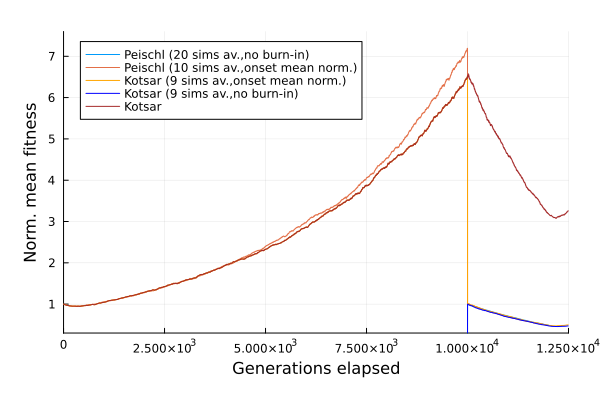

In [13]:
plot(peischl_fitn_front_average,label = "Peischl (20 sims av.,no burn-in)")
plot!(peischl_fitn_norm_front_average2,label = "Peischl (10 sims av.,onset mean norm.)")
plot!(mf_front_average_then_norm,color="orange",label = "Kotsar ($N_IN_BATCH sims av.,onset mean norm.)",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.3,7.6))
plot!(mf_front_average_noburn,color="blue",label = "Kotsar ($N_IN_BATCH sims av.,no burn-in)",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.3,7.6))
plot!(mf_front_average,color="brown",label = "Kotsar")
#plot!(find_mf_theory(1),label = "Theory (analytical)",color="green",legend=:topleft)

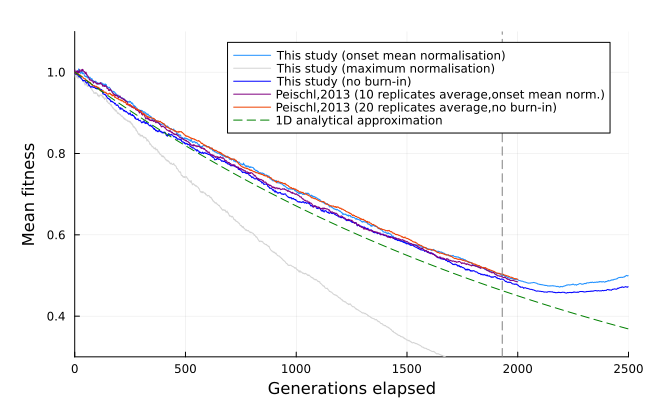

In [14]:
plot(mf_front_average_then_norm[BURN_IN_GEN_N+1:end],color="dodgerblue",label = "This study (onset mean normalisation)",xlabel="Generations elapsed",ylabel="Mean fitness",ylims=(0.3,1.1))
plot!(mf_front_norm_average[BURN_IN_GEN_N+1:end],color="lightgrey",label = "This study (maximum normalisation)",xlabel="Generations elapsed",ylabel="Mean fitness",ylims=(0.3,1.1))
plot!(mf_front_average_noburn[BURN_IN_GEN_N+1:end],color="blue",label = "This study (no burn-in)",xlabel="Generations elapsed",xlims=(0,2500),legend=:topright)
plot!(peischl_fitn_norm_front_average2[BURN_IN_GEN_N+1:end],color="purple",label = "Peischl,2013 (10 replicates average,onset mean norm.)")
plot!(peischl_fitn_front_average[BURN_IN_GEN_N+1:end],color="orangered2",label = "Peischl,2013 (20 replicates average,no burn-in)")
#plot!(find_mf_theory(1)[BURN_IN_GEN_N+1:end],label = "Theory (analytical)",color="green",linestyle=:dot)
plot!(find_mf_theory(1;mu_func=mu_effect)[BURN_IN_GEN_N+1:end],label = "1D analytical approximation",color="green",linestyle=:dash,size=(660,420))
vline!([1930],style=:dash,color=:gray,label=:none)

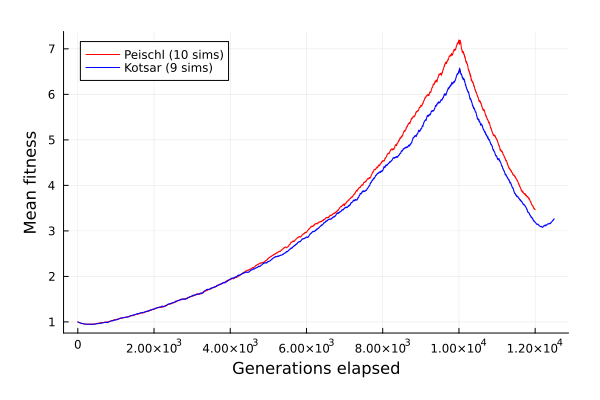

In [15]:
peischl_fitn_front_set2 = [find_front(peischl_fitn_set2[i],min(TOTAL_GEN_N,size(peischl_read[1],1))) for i in 1:N_IN_PEISCHL2]
peischl_fitn_front_matrix2 = reduce(hcat,peischl_fitn_front_set2)'
peischl_fitn_front_average2 = [mean(peischl_fitn_front_matrix2[:,i]) for i in 1:size(peischl_read[1],1)]



plot(peischl_fitn_front_average2,label="Peischl ($N_IN_PEISCHL2 sims)",xlabel="Generations elapsed",ylabel="Mean fitness",color="red")
plot!(mf_front_average,label="Kotsar ($N_IN_BATCH sims)",color="blue")

In [19]:
#= plot(peischl_fitn_norm_front_average2,label="Peischl ($N_IN_PEISCHL2 sims,onset norm.)",xlabel="Generations elapsed",ylabel="Mean fitness",color="red")
plot!(mf_front_norm_average2,label="Kotsar ($N_IN_BATCH sims,onset norm.)",color="blue") =#

In [20]:
#= plot(peischl_fitn_norm_front_average2[BURN_IN_GEN_N+1:end],label="Peischl ($N_IN_PEISCHL2 sims,onset norm.)",xlabel="Generations elapsed",ylabel="Norm. mean fitness",color="red")
plot!(mf_front_norm_average2[BURN_IN_GEN_N+1:end],label="Kotsar ($N_IN_BATCH sims,onset norm.)",color="blue") =#

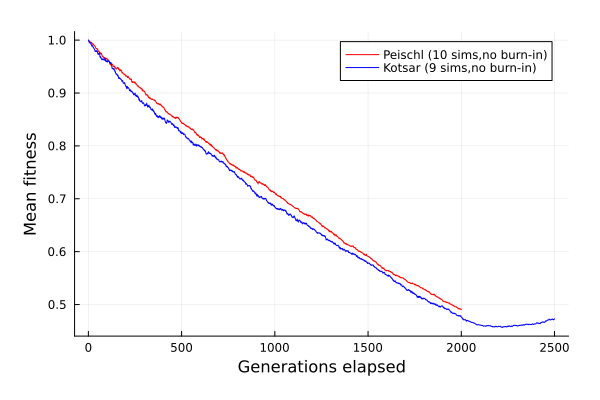

In [18]:
plot(peischl_fitn_front_average[BURN_IN_GEN_N+1:end],label="Peischl ($N_IN_PEISCHL2 sims,no burn-in)",xlabel="Generations elapsed",ylabel="Mean fitness",color="red")
plot!(mf_front_average_noburn[BURN_IN_GEN_N+1:end],label="Kotsar ($N_IN_BATCH sims,no burn-in)",color="blue")